# Pixie: cell clustering notebook

NOTE: this notebook should be run after `2_Pixie_Cluster_Pixels.ipynb`

In [1]:
# import required packages
import json
import os
from datetime import datetime as dt

import feather
import matplotlib.pyplot as plt
import pandas as pd
from alpineer import load_utils
from matplotlib import rc_file_defaults

from ark.phenotyping import (cell_cluster_utils, cell_meta_clustering,
                             cell_som_clustering, weighted_channel_comp)
from ark.utils import data_utils, example_dataset, plot_utils
from ark.utils.metacluster_remap_gui import (MetaClusterGui,
                                             colormap_helper,
                                             metaclusterdata_from_files)

## 0: Set root directory and download the example dataset

Here we are using the example data located in `data/example_dataset`. To use your own data, change `base_dir` to point to your own sub-directory within the data folder.

* `base_dir`: the path to all of your imaging data. Should contain a directory for your images, segmentations, and cell table (which can be generated from `1_Segment_Image_Data.ipynb`). This directory will also store all of the directories/files created during cell clustering.

In [2]:
# define the home directory (should contain pixel_output_dir from pixel clustering notebook)
base_dir = "data_processing"

If you would like to test the features in ark with an example dataset, run the cell below. It will download a dataset consisting of 11 FOVs with 22 channels. You may find more information about the example dataset in the [README](../README.md#example-dataset).

If you are using your own data, skip the cell below.

* `overwrite_existing`: If set to `False`, it will not overwrite existing data in `data/example_dataset`. Recommended setting to `False` if you are running Notebooks 1,2,3 and 4 in succession. Set to `True` if you are just running Notebook 3.

## 1: Load parameters for cell clustering (saved during `2_Pixie_Cluster_Pixels.ipynb`)

`cell_clustering_params_name` should be `cell_clustering_params.json` contained in `{pixel_cluster_prefix}_pixel_output_dir`. Make sure to set `base_dir` and `pixel_output_dir` to the same value used in `2_Pixie_Cluster_Pixels.ipynb`.

NOTE: `{pixel_cluster_prefix}` is set in `2_Pixie_Cluster_Pixels.ipynb`. If you did not explicity set a `{pixel_cluster_prefix}` in `2_Pixie_Cluster_Pixels.ipynb`, the prefix defaults to the timestamp of the run. Please check the run directory (`base_dir` as set in `2_Pixie_Cluster_Pixels.ipynb`) to see the prefix that was used.

In [3]:
# define the name of the folder containing the pixel cluster data
pixel_output_dir = '_pixel_output_dir'

# define the name of the cell clustering params file
cell_clustering_params_name = 'cell_clustering_params.json'

The following params are loaded:

* `fovs`: subset of fovs used for pixel clustering
* `channels`: subset of channels used for pixel clustering
* `tiff_dir`: path to the directory containing your imaging data. Images should be single-channel TIFFs.
* `img_sub_folder`: if `tiff_dir` contains an additional subfolder structure, set to the appropriate folder name (or `None` if no such structure present)
* `segmentation_dir`: path to the directory containing your segmented images (can be generated from `1_Segment_Image_Data.ipynb`)
* `seg_suffix`: suffix plus the file extension of the segmented images for each FOV
* `pixel_data_dir`: name of the directory containing pixel data with the pixel SOM and meta cluster assignments
* `pc_chan_avg_som_cluster_name`: name of the file containing the average channel expression per pixel SOM cluster, used for the visualization of weighted channel average per cell
* `pc_chan_avg_meta_cluster_name`: name of the file containing the average channel expression per pixel meta cluster, used for the visualization of weighted channel average per cell

Additionally, define the following parameter:

* `cell_table_path`: path to the cell table where each row in the table is one cell, must contain `fov`, `label`, and `cell_size` columns. Can be created by `1_Segment_Image_Data.ipynb`, should be placed in `segmentation_dir` by default. You can use either the normalized or arcsinh versions (only columns that are used are `fov`, `label`, and `cell_size`).

In [4]:
# load the params
with open(os.path.join(base_dir, "pixie", pixel_output_dir, cell_clustering_params_name)) as fh:
    cell_clustering_params = json.load(fh)
    
# assign the params to variables
fovs = cell_clustering_params['fovs']
channels = cell_clustering_params['channels']
tiff_dir = cell_clustering_params['tiff_dir']
img_sub_folder = cell_clustering_params['img_sub_folder']
segmentation_dir = cell_clustering_params['segmentation_dir']
seg_suffix = cell_clustering_params['seg_suffix']
pixel_data_dir = cell_clustering_params['pixel_data_dir']
pc_chan_avg_som_cluster_name = cell_clustering_params['pc_chan_avg_som_cluster_name']
pc_chan_avg_meta_cluster_name = cell_clustering_params['pc_chan_avg_meta_cluster_name']

# define the cell table path
cell_table_path = os.path.join(base_dir, 'segmentation', 'cell_table', 'cell_table_size_normalized.csv')

## 2: Preprocess

Set a prefix to be applied to all data directories/files created during cell clustering. If the prefix is not set, a default of the datetime at the start of the run is used.

In [5]:
# explicitly set cell_cluster_prefix to override datetime default
cell_cluster_prefix = "example"

if cell_cluster_prefix is None:
    cell_cluster_prefix = dt.now().strftime('%Y-%m-%dT%H:%M:%S')

The following folders/files will be created with names prefixed by `cell_cluster_prefix`:

* `cell_output_dir`: directory name where the cell clustering outputs are stored
* `cell_som_weights_name`: file name to store the cell SOM weights
* `cluster_counts_name`: file name to store the counts of each pixel cluster per cell
* `cluster_counts_size_norm_name`: same as above, except with each value normalized by the respective cell's size. The data will also contain the cell SOM and meta cluster labels assigned.
* `weighted_cell_channel_name`: file name to store the weighted cell channel expression for each cell. Refer to <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.cell_cluster_utils.compute_p2c_weighted_channel_avg>cell channel weighting docs</a> for how the weighting is computed.
* `cell_som_cluster_count_avg_name`: file name to store the average number of pixel clusters per cell SOM cluster
* `cell_meta_cluster_count_avg_name`: same as above for cell meta clusters
* `cell_som_cluster_channel_avg_name`: file name to store the average weighted channel expression per cell SOM cluster
* `cell_meta_cluster_channel_avg_name`: same as above for cell meta clusters
* `cell_meta_cluster_remap_name`: file name to store the SOM cluster to meta cluster manual mappings created using the GUI below

In [6]:
# define the base output cell folder
cell_output_dir = '%s_cell_output_dir' % cell_cluster_prefix
if not os.path.exists(os.path.join(base_dir, "pixie", cell_output_dir)):
    os.mkdir(os.path.join(base_dir, "pixie", cell_output_dir))
    
# define the paths to cell clustering files, explicitly set the variables to use custom names
cell_som_weights_name = os.path.join("pixie", cell_output_dir, 'cell_som_weights.feather')
cluster_counts_name = os.path.join("pixie", cell_output_dir, 'cluster_counts.feather')
cluster_counts_size_norm_name = os.path.join("pixie", cell_output_dir, 'cluster_counts_size_norm.feather')
weighted_cell_channel_name = os.path.join("pixie", cell_output_dir, 'weighted_cell_channel.feather')
cell_som_cluster_count_avg_name = os.path.join("pixie", cell_output_dir, 'cell_som_cluster_count_avg.csv')
cell_meta_cluster_count_avg_name = os.path.join("pixie", cell_output_dir, 'cell_meta_cluster_count_avg.csv')
cell_som_cluster_channel_avg_name = os.path.join("pixie", cell_output_dir, 'cell_som_cluster_channel_avg.csv')
cell_meta_cluster_channel_avg_name = os.path.join("pixie", cell_output_dir, 'cell_meta_cluster_channel_avg.csv')
cell_meta_cluster_remap_name = os.path.join("pixie", cell_output_dir, 'cell_meta_cluster_mapping.csv')

Additionally, define the following variable:

* `pixel_cluster_col`: whether to use the pixel SOM or meta cluster counts for cell clustering. Must be either `'pixel_som_cluster'` or `'pixel_meta_cluster_rename'`. Note that if you did not explicitly rename your pixel meta clusters in `2_Pixie_Cluster_Pixels.ipynb`, the default numeric names will be used.

In [7]:
# define the type of pixel cluster to aggregate on
pixel_cluster_col = 'pixel_meta_cluster_rename'

# depending on which pixel_cluster_col is selected, choose the pixel channel average table accordingly
if pixel_cluster_col == 'pixel_som_cluster':
    pc_chan_avg_name = pc_chan_avg_som_cluster_name
elif pixel_cluster_col == 'pixel_meta_cluster_rename':
    pc_chan_avg_name = pc_chan_avg_meta_cluster_name

Generate the input data for the cell SOM. This computes the counts of each pixel cluster per cell, both raw and normalized by cell size.

If both datasets already exist, load them in instead.

In [8]:
if os.path.exists(os.path.join(base_dir, cluster_counts_name)) and os.path.exists(os.path.join(base_dir, cluster_counts_size_norm_name)):
    # load the data if it exists
    cluster_counts = feather.read_dataframe(os.path.join(base_dir, cluster_counts_name))
    cluster_counts_size_norm = feather.read_dataframe(os.path.join(base_dir, cluster_counts_size_norm_name))
else:
    # generate the preprocessed data 
    cluster_counts, cluster_counts_size_norm = cell_cluster_utils.create_c2pc_data(
        fovs, os.path.join(base_dir, pixel_data_dir), cell_table_path, pixel_cluster_col
    )

    # write both unnormalized and normalized input data for reference
    feather.write_dataframe(
        cluster_counts,
        os.path.join(base_dir, cluster_counts_name),
        compression='uncompressed'
    )
    feather.write_dataframe(
        cluster_counts_size_norm,
        os.path.join(base_dir, cluster_counts_size_norm_name),
        compression='uncompressed'
    )
    
# define the count columns found in cluster_counts_norm
cell_som_cluster_cols = cluster_counts_size_norm.filter(
    regex=f'{pixel_cluster_col}.*'
).columns.values

Generate the weighted cell channel expression file. This data will be needed to compute the weighted average channel expression per cell cluster (the data stored in `cell_som_cluster_channel_avg_name` and `cell_meta_cluster_channel_avg_name`). See documentation of `compute_p2c_weighted_channel_avg` for how weighted cell channel average is computed: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.cell_cluster_utils.compute_p2c_weighted_channel_avg>cell channel weighting docs</a>.

If this file already exists, skip this step.

In [9]:
# depending on which pixel_cluster_col is selected, choose the pixel channel average table accordingly
if pixel_cluster_col == 'pixel_som_cluster':
    pc_chan_avg_name = pc_chan_avg_som_cluster_name
elif pixel_cluster_col == 'pixel_meta_cluster_rename':
    pc_chan_avg_name = pc_chan_avg_meta_cluster_name

if not os.path.exists(os.path.join(base_dir, weighted_cell_channel_name)):
    # generate the weighted cell channel expression data
    pixel_channel_avg = pd.read_csv(os.path.join(base_dir, pc_chan_avg_name))
    weighted_cell_channel = weighted_channel_comp.compute_p2c_weighted_channel_avg(
        pixel_channel_avg,
        channels,
        cluster_counts,
        fovs=fovs,
        pixel_cluster_col=pixel_cluster_col
    )

    # write the data to weighted_cell_channel_name
    feather.write_dataframe(
        weighted_cell_channel,
        os.path.join(base_dir, weighted_cell_channel_name),
        compression='uncompressed'
    )

## 3: Cell clustering

### 3.1: Train cell SOM

Train the cell SOM on the size-normalized number of pixel clusters per cell (the data stored in `cluster_counts_size_norm_name`). Training is done using the self-organizing map (SOM) algorithm. Note that each of the pixel SOM/meta cluster columns are normalized by their 99.9% value prior to training.

For a full set of parameters you can customize for `train_cell_som`, please consult <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.cell_cluster_utils.train_cell_som>cell training docs</a>.

In [10]:
# create the cell SOM weights
cell_pysom = cell_som_clustering.train_cell_som(
    fovs,
    base_dir,
    cell_table_path=cell_table_path,
    cell_som_cluster_cols=cell_som_cluster_cols,
    cell_som_input_data=cluster_counts_size_norm,
    som_weights_name=cell_som_weights_name,
    num_passes=1,
    seed=42
)

Training SOM


c:\Users\miles\GitHub\ark-analysis-implementation\.venv\lib\site-packages\ark\phenotyping\cluster_helpers.py:364: UserWarning: Cell SOM already trained on specified columns
  warnings.warn('Cell SOM already trained on specified columns')


### 3.2: Assign cell SOM clusters

Use the weights learned from `train_cell_som` to assign cell clusters to the dataset. Note that this is done on the size-normalized pixel cluster counts table. As with `train_pixel_som`, each of the columns are normalized by their 99.9% value prior to assigning a cell SOM cluster label.

`generate_som_avg_files` will compute the average number of pixel clusters per cell SOM cluster, as well as the number of cells in each cell SOM cluster (the data placed in `cell_som_cluster_count_avg_name`). This is needed for cell consensus clustering.

In [11]:
# use cell SOM weights to assign cell clusters
cluster_counts_size_norm = cell_som_clustering.cluster_cells(
    base_dir,
    cell_pysom,
    cell_som_cluster_cols=cell_som_cluster_cols
)

# intermediate saving of cell data with SOM labels assigned
feather.write_dataframe(
    cluster_counts_size_norm,
    os.path.join(base_dir, cluster_counts_size_norm_name),
    compression='uncompressed'
)

# generate the SOM cluster summary files
cell_som_clustering.generate_som_avg_files(
    base_dir,
    cluster_counts_size_norm,
    cell_som_cluster_cols=cell_som_cluster_cols,
    cell_som_expr_col_avg_name=cell_som_cluster_count_avg_name
)

SOM clusters already assigned to each cell
Already generated average expression file for each cell SOM column, skipping


### 3.3: Run cell consensus clustering

Use consensus hierarchical clustering to cluster cell SOM clusters into a user-defined number of meta clusters. The consensus clusters are trained on the average number of pixel clusters across all cell SOM clusters (the data stored in `cell_som_cluster_count_avg_name`). These values are z-scored and capped at the value specified in the `cap` argument prior to consensus clustering. This helps improve meta clustering performance.

After consensus clustering, the following are computed by `generate_meta_avg_files`:

* The average number of pixel clusters across all cell meta clusters, and the number of cells per meta cluster (the data placed in `cell_meta_cluster_count_avg_name`)
* The meta cluster mapping for each cell SOM cluster in `cell_som_cluster_count_avg_name` (data is resaved, same data except with an associated meta cluster column)

`generate_wc_avg_files` also creates the following:

* The weighted channel average across all cell clusters (the data placed in `cell_som_cluster_channel_avg_name` and `cell_meta_cluster_channel_avg_name`). This will be done for both `'cell_som_cluster'` and `'cell_meta_cluster'`.

For a full set of parameters you can customize for `cell_consensus_cluster`, please consult <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.cell_cluster_utils.cell_consensus_cluster>cell consensus clustering docs</a>

* `max_k`: the number of consensus clusters desired
* `cap`: used to clip z-scored values prior to consensus clustering (in the range `[-cap, cap]`)

In [12]:
max_k = 20
cap = 3

# run hierarchical clustering using average count of pixel clusters per cell SOM cluster
cell_cc, cluster_counts_size_norm = cell_meta_clustering.cell_consensus_cluster(
    base_dir,
    cell_som_cluster_cols=cell_som_cluster_cols,
    cell_som_input_data=cluster_counts_size_norm,
    cell_som_expr_col_avg_name=cell_som_cluster_count_avg_name,
    max_k=max_k,
    cap=cap
)

# intermediate saving of cell data with SOM and meta labels assigned
feather.write_dataframe(
    cluster_counts_size_norm,
    os.path.join(base_dir, cluster_counts_size_norm_name),
    compression='uncompressed'
)

# generate the meta cluster summary files
cell_meta_clustering.generate_meta_avg_files(
    base_dir,
    cell_cc,
    cell_som_cluster_cols=cell_som_cluster_cols,
    cell_som_input_data=cluster_counts_size_norm,
    cell_som_expr_col_avg_name=cell_som_cluster_count_avg_name,
    cell_meta_expr_col_avg_name=cell_meta_cluster_count_avg_name
)

# generate weighted channel summary files
weighted_channel_comp.generate_wc_avg_files(
    fovs,
    channels,
    base_dir,
    cell_cc,
    cell_som_input_data=cluster_counts_size_norm,
    weighted_cell_channel_name=weighted_cell_channel_name,
    cell_som_cluster_channel_avg_name=cell_som_cluster_channel_avg_name,
    cell_meta_cluster_channel_avg_name=cell_meta_cluster_channel_avg_name
)

Meta clusters already assigned to each cell
Already generated average expression file for cell meta clusters, skipping
Already generated average weighted channel expression files, skipping


## 4: Visualize results

### 4.1: Interactive adjustments to relabel cell meta clusters

The visualization shows the z-scored average pixel cluster count expression per cell SOM and meta cluster. The heatmaps are faceted by cell SOM clusters on the left and cell meta clusters on the right.

## Usage

### Quickstart
- **Select**: Left Click
- **Remap**: **New metacluster button** or Right Click
- **Edit Metacluster Name**: Textbox at bottom right of the heatmaps.

### Selection and Remapping details
- To select a SOM cluster, click on its respective position in the **selected** bar. Click on it again to deselect.
- To select a meta cluster, click on its corresponding color in the **metacluster** bar. Click on it again to deselect.
- To remap the selected clusters, click the **New metacluster** button (alternatively, right click anywhere). Note that remapping an entire metacluster deletes it.
- To clear the selected SOM/meta clusters, use the **Clear Selection** button.
- **After remapping a meta cluster, make sure to deselect the newly created one to prevent unwanted combinations.**

### Other features and notes
- You will likely need to zoom out to see the entire visualization. To toggle Zoom, use Ctrl -/Ctrl + on Windows or ⌘ +/⌘ - on Mac.
- The bars at the top show the number of cells in each SOM cluster.
- The text box at the bottom right allows you to rename a particular meta cluster. This can be useful as remapping may cause inconsistent numbering. **You cannot use the same name for different meta clusters; doing so will cause the next step to fail.**
- Adjust the z-score limit using the slider on the bottom left to adjust your dynamic range.
- When meta clusters are combined or a meta cluster is renamed, the change is immediately saved to `cell_meta_cluster_remap_name`.
- You won't be able to advance until you've clicked `New metacluster` or renamed a meta cluster at least once. If you do not want to make changes, just click `New metacluster` to trigger a save before continuing.

In [16]:
%matplotlib widget
rc_file_defaults()
plt.ion()

cell_mcd = metaclusterdata_from_files(
    os.path.join(base_dir, cell_som_cluster_count_avg_name),
    cluster_type='cell',
    prefix_trim=pixel_cluster_col + '_'
)
cell_mcd.output_mapping_filename = os.path.join(base_dir, cell_meta_cluster_remap_name)
cell_mcg = MetaClusterGui(cell_mcd, width=9)

skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints


Relabel the cell meta clusters using the mapping, and recompute the meta cluster average files with the new meta cluster names.

In [14]:
# rename the meta cluster values in the cell dataset
cluster_counts_size_norm = cell_meta_clustering.apply_cell_meta_cluster_remapping(
    base_dir,
    cluster_counts_size_norm,
    cell_meta_cluster_remap_name
)

# intermediate saving of cell data with SOM, raw meta, and renamed meta labels assigned
feather.write_dataframe(
    cluster_counts_size_norm,
    os.path.join(base_dir, cluster_counts_size_norm_name),
    compression='uncompressed'
)

# recompute the mean column expression per meta cluster and apply these new names to the SOM cluster average data
cell_meta_clustering.generate_remap_avg_count_files(
    base_dir,
    cluster_counts_size_norm,
    cell_meta_cluster_remap_name,
    cell_som_cluster_cols,
    cell_som_cluster_count_avg_name,
    cell_meta_cluster_count_avg_name,
)

# recompute the mean weighted channel expression per meta cluster and apply these new names to the SOM channel average data
weighted_channel_comp.generate_remap_avg_wc_files(
    fovs,
    channels,
    base_dir,
    cluster_counts_size_norm,
    cell_meta_cluster_remap_name,
    weighted_cell_channel_name,
    cell_som_cluster_channel_avg_name,
    cell_meta_cluster_channel_avg_name
)

Using re-mapping scheme to re-label cell meta clusters
Re-compute average value of each training column specified per cell meta cluster
Re-assigning meta cluster column in cell SOM cluster average pixel cluster counts data
Re-compute average weighted channel expression across cell meta clusters
Re-assigning meta cluster column in cell SOM cluster average weighted channel data


PermissionError: [Errno 13] Permission denied: 'data_processing\\pixie\\example_cell_output_dir\\cell_som_cluster_channel_avg.csv'

Generate the color scheme returned by the interactive reclustering process. This will be for visualizing the weighted channel average heatmaps and the cell phenotype maps.

In [ ]:
raw_cmap, renamed_cmap = colormap_helper.generate_meta_cluster_colormap_dict(
    cell_mcd.output_mapping_filename,
    cell_mcg.im_cl.cmap,
    cluster_type='cell'
)

### 4.2: Weighted cell SOM cluster average heatmap over channels (z-scored)

c:\Users\miles\GitHub\ark-analysis-implementation\.venv\lib\site-packages\ark\analysis\visualize.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


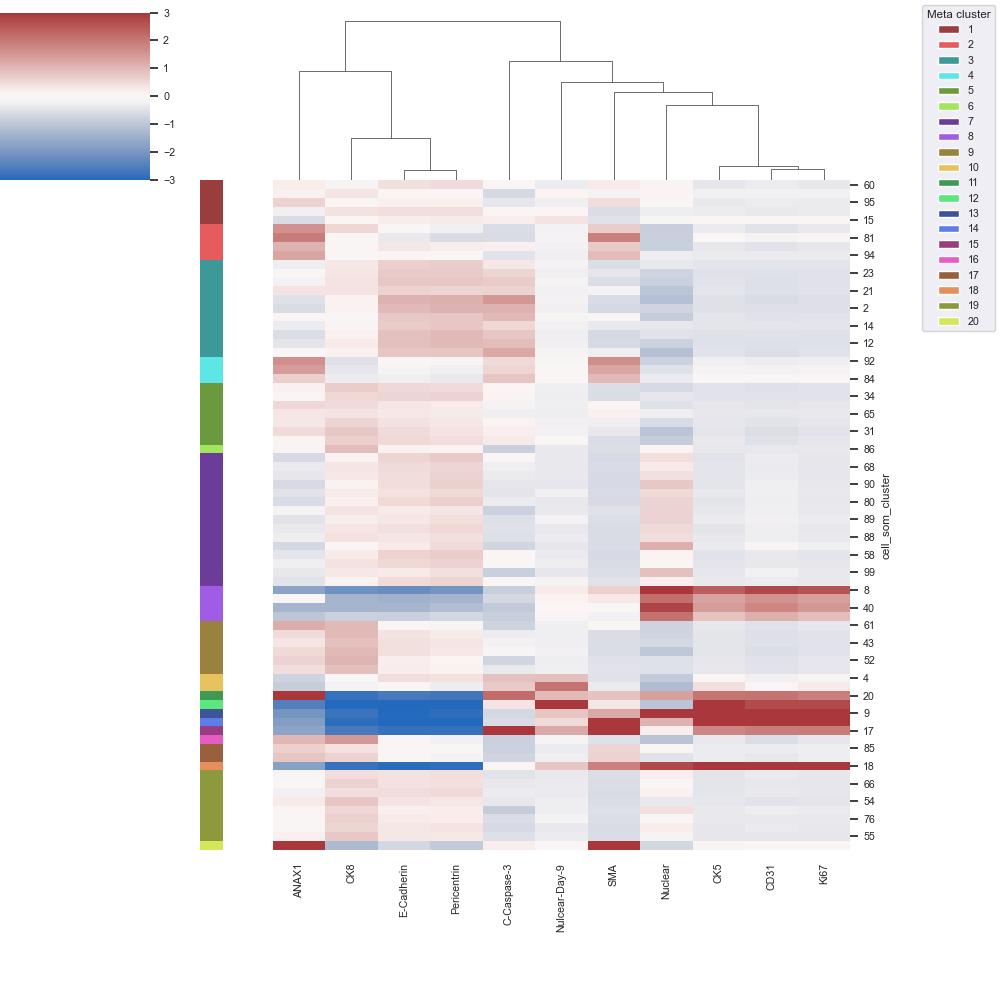

In [ ]:
weighted_channel_comp.generate_weighted_channel_avg_heatmap(
    os.path.join(base_dir, cell_som_cluster_channel_avg_name),
    'cell_som_cluster',
    channels,
    raw_cmap,
    renamed_cmap
)

### 4.3: Weighted cell meta cluster average heatmap over channels (z-scored)

c:\Users\miles\GitHub\ark-analysis-implementation\.venv\lib\site-packages\ark\analysis\visualize.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


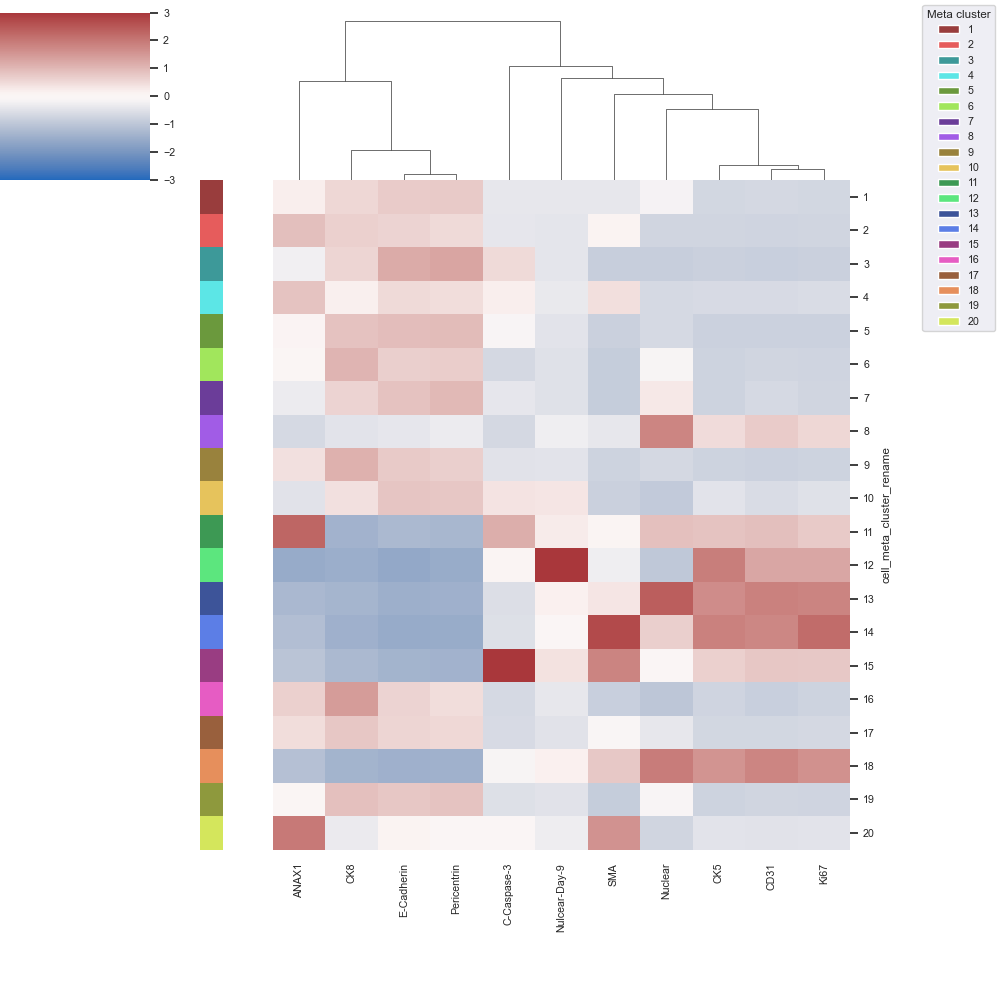

In [ ]:
weighted_channel_comp.generate_weighted_channel_avg_heatmap(
    os.path.join(base_dir, cell_meta_cluster_channel_avg_name),
    'cell_meta_cluster_rename',
    channels,
    raw_cmap,
    renamed_cmap
)

### 4.4: Generate cell phenotype maps

Generate cell phenotype maps, in which each pixel in the image corresponds to its cell meta cluster. Run this cell if you wish to create cell cluster mask images for downstream analysis.

In [ ]:
# select fovs to display
subset_cell_fovs = ['fov0', 'fov1']

In [ ]:
# generate and save the cell cluster masks for each fov in subset_cell_fovs
data_utils.generate_and_save_cell_cluster_masks(
    fovs=subset_cell_fovs,
    save_dir=os.path.join(base_dir, "pixie", cell_output_dir),
    seg_dir=os.path.join(base_dir, segmentation_dir),
    cell_data=cluster_counts_size_norm,
    seg_suffix=seg_suffix,
    sub_dir='cell_masks',
    name_suffix='_cell_mask'
)

Cell Cluster Mask Generation:   0%|          | 0/2 [00:00<?, ?FOVs/s]

c:\Users\miles\GitHub\ark-analysis-implementation\.venv\lib\site-packages\numba\typed\typeddict.py:34: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.
  d[key] = value


Save the colored cell masks for each FOV in `subset_cell_fovs`.

In [ ]:
plot_utils.save_colored_masks(
    fovs=subset_cell_fovs,
    mask_dir=os.path.join(base_dir, "pixie",cell_output_dir, "cell_masks"),
    save_dir=os.path.join(base_dir, "pixie",cell_output_dir, "cell_mask_colored"),
    cluster_id_to_name_path=os.path.join(base_dir, cell_meta_cluster_remap_name),
    metacluster_colors=raw_cmap,
    cluster_type="cell"
)

Saving colored masks: 100%|██████████| 2/2 [00:00<00:00, 42.55FOVs/s, FOV=fov1]


Load a subset of the cell cluster masks that you would like to preview.

In [ ]:
for cell_fov in subset_cell_fovs:
    cell_cluster_mask = load_utils.load_imgs_from_dir(
        data_dir = os.path.join(base_dir, "pixie", cell_output_dir, "cell_masks"),
        files=[cell_fov + "_cell_mask.tiff"],
        trim_suffix="_cell_mask",
        match_substring="_cell_mask",
        xr_dim_name="cell_mask",
        xr_channel_names=None,
    )

    plot_utils.plot_pixel_cell_cluster(
        cell_cluster_mask,
        [cell_fov],
        os.path.join(base_dir, cell_meta_cluster_remap_name),
        metacluster_colors=raw_cmap,
        cluster_type='cell',
        erode=True
    )

AttributeError: module 'ark.utils.plot_utils' has no attribute 'plot_pixel_cell_cluster'

### 4.5: Append consensus cluster labels to cell table

The cell table with cell meta cluster labels is saved to `{cell_table_path}_cell_labels.csv`

In [ ]:
cell_cluster_utils.add_consensus_labels_cell_table(
    base_dir, cell_table_path, cluster_counts_size_norm
)

### 4.6: Save images for Mantis Viewer

Mantis Viewer is a visualization tool for multi-dimensional imaging in pathology. Learn more about Mantis Viewer in the [README](../README.md#mantis-viewer).

In [ ]:
plot_utils.create_mantis_dir(
    fovs=subset_cell_fovs,
    mantis_project_path=os.path.join(base_dir, "mantis"),
    img_data_path=tiff_dir,
    mask_output_dir=os.path.join(base_dir, "pixie", cell_output_dir, "cell_masks"),
    mapping = os.path.join(base_dir, cell_meta_cluster_remap_name),
    seg_dir=os.path.join(base_dir, segmentation_dir),
    cluster_type='cell',
    mask_suffix="_cell_mask",
    seg_suffix_name=seg_suffix,
    img_sub_folder=img_sub_folder
)